In [1]:
laptop = True

if laptop:
    rootF = 'C:/Users/goethas/'
else:
    rootF = '/home/sarah/'

In [2]:
import os
import sys
from matplotlib.pyplot import *
from numpy import *
from tqdm.auto import tqdm
import itertools
import csv
import h5py
import matplotlib.gridspec as gds
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.patches as pcs
import pickle
import pandas as pd
from scipy.io import loadmat
from scipy import interpolate

# Import diverse functions
from shared.functions import fit_gaussian, get_ellipse_parameters, plot_dendrogram
from shared.save_load import *

# For clustering
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering

# Load data

### Baden data

In [3]:
Folder = rootF + '/Documents/Myopia/Data analysis/calcium_comparison/'

# Baden data
baden = loadmat(Folder + 'baden_data.mat')
# Calcium transform data
calcium = loadmat(Folder + 'calcium_conversion.mat')

chirp_stim = baden['chirp_stim'][:,0]/max(baden['chirp_stim'][:,0]) # the stimulus
chirp_stim_time = baden['chirp_stim_time'][0,:] + 2   # the stimulus times, 2 seconds later than my stim
baden_time_original = baden['chirp_time'][0,:]   # 2 seconds later than my stim
group_idx = baden['group_idx'] 
psth_euler = baden['chirp_avg'] # the average calcium traces

# Baden types : load cell types names
euler_labels_f = open(Folder + 'Baden Types');
euler_labels_f = csv.reader(euler_labels_f,delimiter=",");
euler_labels={}
c=0
for row in euler_labels_f:
    if c==0:
        stim_cond_head = row
        c=1
    else:
        euler_labels[c-1]= row
        c+=1     
        
n_baden_types = len(euler_labels)

In [4]:
print ('Euler labels :', n_baden_types, 'types')
for i in euler_labels:
    print(i, euler_labels[i][0])

Euler labels : 32 types
0 OFF local OS
1 OFF DS
2 OFF step
3 OFF slow
4 OFF alpha sustained
5 ON-OFF JAM-B
6 OFF sustained
7 OFF alpha transient
8 OFF mini alpha transient
9 ON-OFF local-edge W3
10 ON-OFF local
11 ON-OFF DS 1
12 ON-OFF DS 2
13 ON-OFF local OS
14 ON step
15 ON DS transient
16 ON local transient OS
17 ON transient
18 ON transient large
19 ON high frequency
20 ON low frequency
21 ON sustained
22 ON mini alpha
23 ON alpha
24 ON DS sustained 1
25 ON DS sustained 2
26 ON slow
27 ON constrast suppression
28 ON DS sustained 3
29 ON local sustained OS
30 OFF suppression 1
31 OFF suppression 2


### Our chirp stimulation

In [18]:
# Get Euler stim profile

def get_euler():
    if laptop:
        vec_path = 'E:/MEA data/exp19/STIMS/Euler/'
    else:
        vec_path = '/media/sarah/Sarah_1/MEA data/exp19/STIMS/Euler/'
    vec_path = vec_path + r"euler.vec"
    euler_vec = np.genfromtxt(vec_path)

    return (euler_vec[150:1750,1]/max(euler_vec[150:1750,1])) #return in 100ms steps

# euler_vec = get_euler()

# # Plot
# figure(figsize = (16,4))
time_stim = np.linspace(0,32,50*32+1)[:-1]
time = np.linspace(0,32,321)[:-1]
# # Our chirp
# plot(time_stim, euler_vec, label='our chirp')
# euler_vec.shape
# euler_vec[::5].shape,time.shape
# # Baden chirp
# plot(chirp_stim_time ,chirp_stim+1.5, label = 'Baden chirp')
# chirp_stim_time.shape, chirp_stim.shape
# legend(frameon=False)

# Comparison range:
comp_range = [0.1,31.9]         # to avoid prestep effects ### why 0.1 and not 2 ?
delta_range = comp_range[1]-comp_range[0]
time_common = np.linspace(comp_range[0],comp_range[1],int(delta_range/0.05) +2)

### Euler calcium data

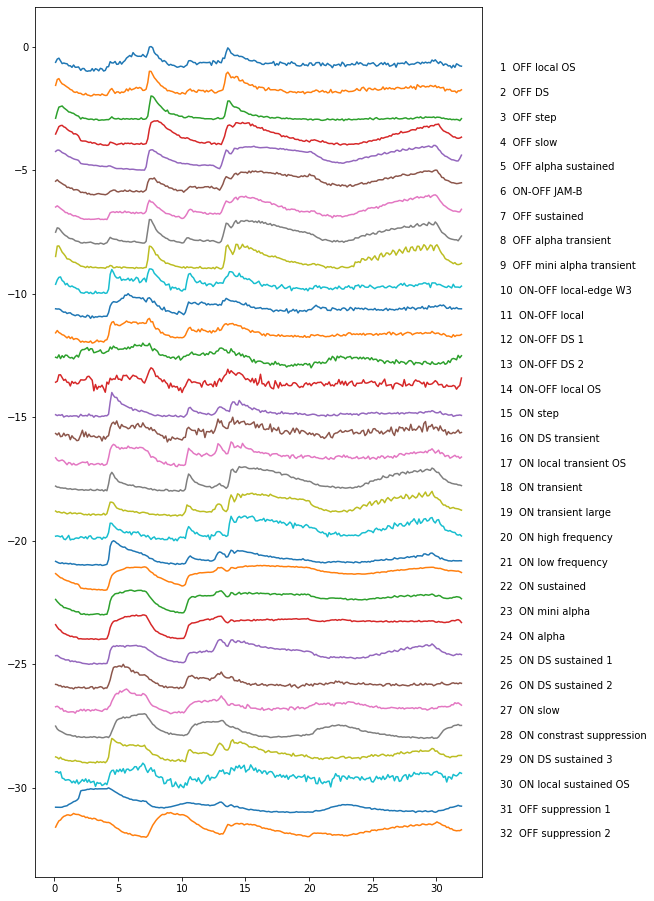

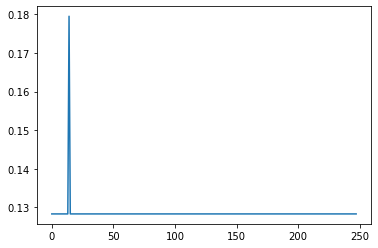

In [13]:
# Generate Baden type traces

# the two additional seconds at the end of Baden stim that will be stitched in the beginning
baden_time = baden_time_original+2
baden_first = baden_time[-15:]-32 
baden_time = np.append(baden_first,baden_time[:-15])

# we do the same for the calcium traces
Baden_types = []

figure(figsize=(8,16))

for i in np.arange(n_baden_types)+1:
    trace = np.mean(psth_euler[:,(group_idx==i)[:,0]],1)
    trace = trace-min(trace)
    trace = trace/max(trace)
    trace = np.append(trace[-15:],trace[:-15])                # I stitch las 2 s in the beggining so that it is 
                                                              #  the same as my experimental stim
    Baden_types.append(trace)
    plot(baden_time,trace-i)
    text(35,-i,str(i)+'  '+euler_labels[i-1][0])

figure()
plot(diff(baden_time))

### Clustering results

From Analyse_cell_type.ipynb

In [14]:
# experiment data
exp = 20230105
exp_path = rootF + '/Documents/Myopia/Data analysis/Blur experiments/exp' + str(exp) + '/'
clustering_data = exp_path + str(exp) + '_clustermodel_clus14'
model, psth_z = load_obj(clustering_data)

labels = model.labels_
exp_labels = np.sort(np.unique(labels))
psth_z.shape, 'Ncells  - Ndatapoints'

((143, 320), 'Ncells  - Ndatapoints')

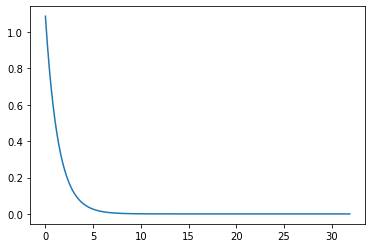

In [15]:
# functions for calcium traces

def calcium_exp(x):
    a =           0
    b =       1.086 
    c =       1.747 -1.0              ##################### changes here
    val = a+b*np.exp(-c*x)
    return val

def toCalciumLinear(time_sequence, spike_train):
    calcium_filter = calcium_exp(time_sequence);
    
    stitch3 = np.append(spike_train,[spike_train,spike_train])
    
    calcium_trace = np.convolve(stitch3, calcium_filter, 'full')[len(spike_train):len(spike_train)*2];
    calcium_trace = calcium_trace-min(calcium_trace)
    calcium_trace=calcium_trace/max(calcium_trace)
    return calcium_trace
    

calcium_filter = calcium_exp(time);
plot(time,calcium_filter)

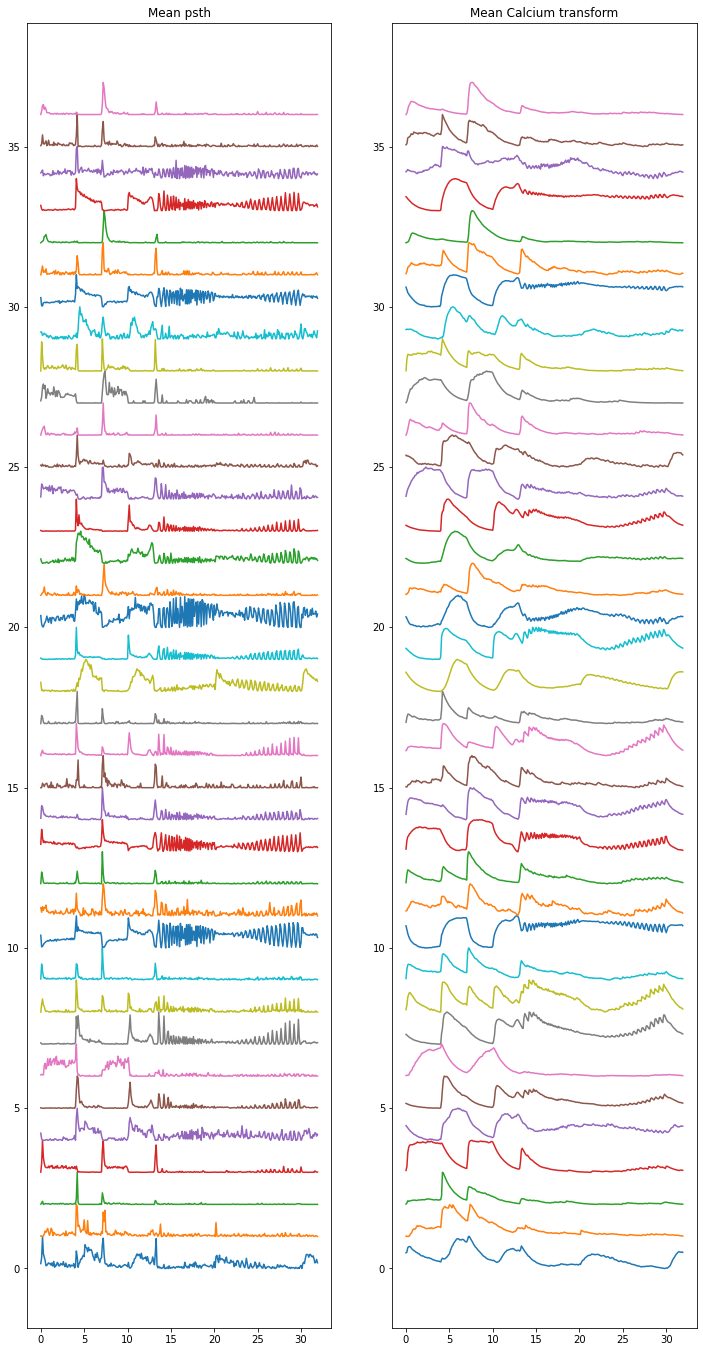

In [16]:
# Generate experiment type traces
Exp_types = []
fig = figure(figsize=(12,24))
fig.add_subplot(1,2,1)
for i in exp_labels:
    trace = np.mean(psth_z[(labels==i),:],0)
    trace = trace-min(trace)
    trace = trace/max(trace)
    Exp_types.append(trace)
    plot(time,trace+i)
    title('Mean psth')

# Experiment to calcium
Exp_types_Ca = {}
fig.add_subplot(1,2,2)
for i in exp_labels:
    trace = toCalciumLinear(time,Exp_types[i])
    Exp_types_Ca[i] = trace
    plot(time,trace+i)
    title('Mean Calcium transform')

# Correlate groups

In [19]:
# Interpolate calcium traces (Baden and transformed traces)
Baden_common = {}
for i in np.arange(n_baden_types):
    f = interpolate.interp1d(baden_time, Baden_types[i])
    Baden_common[i] = f(time_common)   # use interpolation function returned by `interp1d`

Exp_common={}
for i in exp_labels:
    f = interpolate.interp1d(time, Exp_types_Ca[i])
    Exp_common[i] = f(time_common)   # use interpolation function returned by `interp1d`

n_matches = 29
corr_table = np.zeros([len(exp_labels),n_baden_types]) 
corr_match = np.zeros([len(exp_labels),n_baden_types])
corr_match_vals = np.zeros([len(exp_labels),n_baden_types])
delta_match = np.zeros([len(exp_labels),n_baden_types+1])

# For each of our generated calcium type we compute the corr coef with each Baden type
for i in exp_labels:
    for j in np.arange(n_baden_types):
        corr_table[i,j] = np.corrcoef(Exp_common[i], Baden_common[j])[0,1]
    # For each calcium type, sort de corr coefs in descending order (max first)
    corr_match[i,:] = np.flip(np.argsort(corr_table[i,:])[-32:]) # sorted indices
    corr_match_vals[i,:] = corr_table[i,:][np.flip([np.argsort(corr_table[i,:])[-32:]])] # sorted corr coef values
    # Select the 10 larger corr coefs and store the difference with the next one
    for j in np.arange(10):
        delta_match[i,j] = corr_match_vals[i,j]-corr_match_vals[i,j+1]  

['OFF suppression 1']


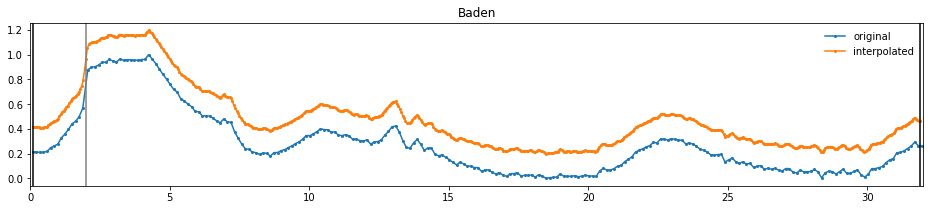

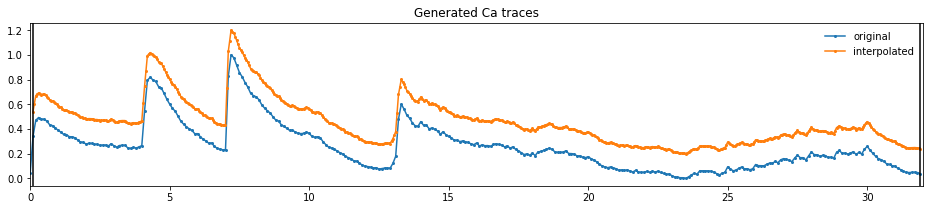

In [20]:
# Compare original and interpolated traces

# Baden traces
figure(figsize=(16,3))
idx = 30
title('Baden')
plot(baden_time, Baden_types[idx], '-o', ms=2, label = 'original')
plot(time_common, Baden_common[idx]+0.2, 'o-', ms=2, label = 'interpolated')
axvline(comp_range[0],color='k')
axvline(comp_range[1],color='k')
axvline(2,color='gray')
xlim([0,32])
legend(frameon=False)
print(euler_labels[idx])

# Generated calcium traces
figure(figsize=(16,3))
idx = 9
title('Generated Ca traces')
plot(time, Exp_types_Ca[idx], '-o', ms=2, label='original')
plot(time_common, Exp_common[idx]+0.2, 'o-', ms=2, label='interpolated')
axvline(comp_range[0],color='k')
axvline(comp_range[1],color='k')
xlim([0,32])    
legend(frameon=False)


(array([0.8724196 , 0.874314  , 0.88164294, 0.89041787, 0.89989632,
        0.90501934, 0.93055536, 0.9378513 , 0.93939019, 0.94523288]),
 0.7605025882872498,
 0.776206780589244)

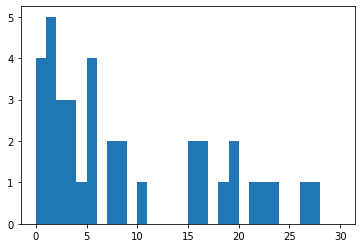

In [21]:
# Histogram of the difference between the first and second corr coef, for all cells
hist(delta_match[:,0]*100, bins=linspace(0,30,31))

np.sort(corr_match_vals[:,0])[-10:], np.median(corr_match_vals[:,0]), np.mean(corr_match_vals[:,0])

(array([1., 2., 0., 0., 0., 0., 0., 0., 5., 0., 0., 1., 1., 1., 0., 0., 0.,
        0., 0., 0., 0., 3., 0., 0., 2., 4., 2., 4., 0., 6., 5., 0.]),
 array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5, 23.5, 24.5, 25.5, 26.5, 27.5, 28.5, 29.5, 30.5, 31.5, 32.5]),
 <BarContainer object of 32 artists>)

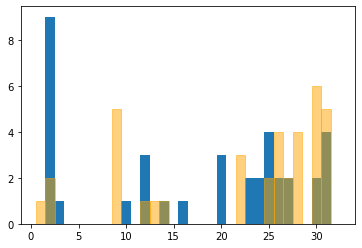

In [22]:
# Histo of the indices of first and second largest corr coefs
hist(corr_match[:,0], bins=np.arange(33)+0.5)
hist(corr_match[:,1], bins=np.arange(33)+0.5,fc='orange',ec='orange',alpha=0.5)

# Manual selection of Groups

In [23]:
fsave = exp_path + 'cells_characterization_data_with_cluster_type_' + str(exp) 
cell_data = load_obj(fsave)

fsave = exp_path + str(exp) + '_selected_cells_clustering'
selected_cells = np.array(load_obj(fsave))

match 3   3 Baden  2
match 2   3 Baden  12
match 4   3 Baden  13
match 1   3 Baden  30
match 0   3 Baden  31


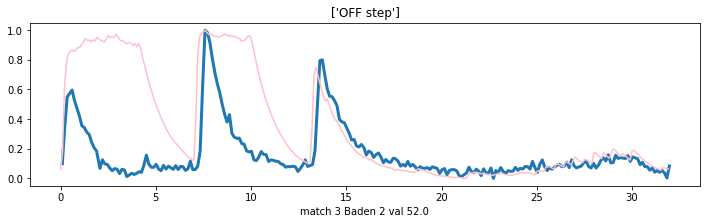

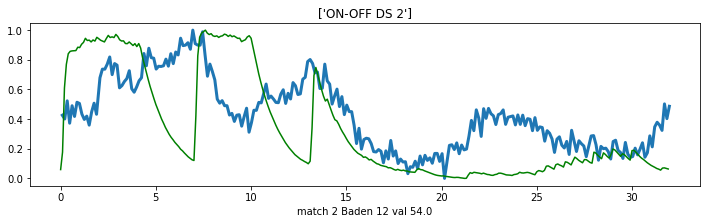

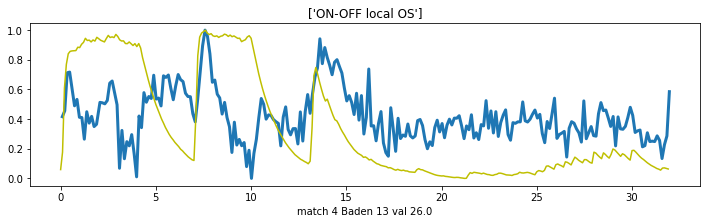

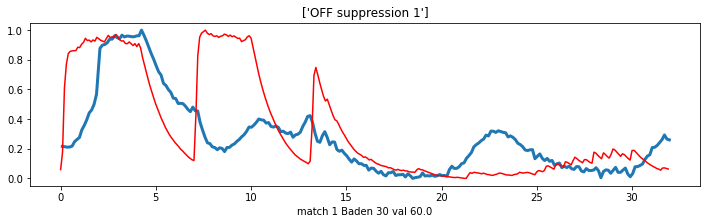

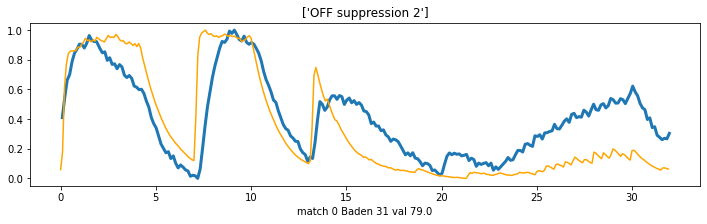

In [74]:
sel_badens = np.arange(32)

# The generated calcium trace we look at
sel_cells = [3]

n_match_sel = 5 # number of best matching Baden traces we look at for manual selection

colors = ['orange','r','g','pink','y','gray','k','c','m','darkgray','coral','gold','plum','wheat','navy']
#             0     1   2    3     4    5     6   7   8      9         10      11     12      13     14

# For each generated calcium trace we look at the first 5 best matching Baden traces
for i in sel_badens:
    Plot = False
    for j in sel_cells:
        for n_match in np.arange(n_match_sel):
            if corr_match[j, n_match]==i:
                if not(Plot): 
                    figure(figsize=(12,3))
                    # Blue: Baden type
                    plot(baden_time, Baden_types[i], lw=3)
                    title(euler_labels[i])
                    Plot=True
                if Plot:
                    # Other colors: matched calcium traces
                    plot(time, Exp_types_Ca[j], color=colors[n_match%15])
                    xlabel('match ' + str(n_match) + ' Baden ' + str(i) + ' val '+str(np.round(corr_match_vals[j,n_match]*100)) )
                    print('match', str(n_match),' ', j, 'Baden ',i)
                    
# Manually selected Baden types
manual_selection = corr_match[:,0].astype('int')

### CLUS 14
# indices are cluster groupe number, n match
manual_selection[0] = corr_match[0,5] # ON OFF local
manual_selection[1] = corr_match[1,0] # ???
manual_selection[2] = corr_match[2,5] # ON step
manual_selection[3] = corr_match[3,0] # OFF supp 2 or OFF step ??
manual_selection[4] = corr_match[4,0] # ON slow
manual_selection[5] = corr_match[5,0] # ON low freq
manual_selection[6] = corr_match[6,0] # OFF suppression 1 
manual_selection[7] = corr_match[7,0] # ON loc trans OS
manual_selection[8] = corr_match[8,5] # ON OFF local wedge 3
manual_selection[9] = corr_match[9,1] # ON OFF local wedge 3
manual_selection[10] = corr_match[10,0] # ON alpha
manual_selection[11] = corr_match[11,1] # OFF DS
manual_selection[12] = corr_match[12,2] # OFF local OS
manual_selection[13] = corr_match[13,4] # OFF alpha sustained 
manual_selection[14] = corr_match[14,4] # OFF alpha transient
manual_selection[15] = corr_match[15,0] # OFF step
manual_selection[16] = corr_match[16,5] # ON high freq
manual_selection[17] = corr_match[17,4] # ON OFF DS 2
manual_selection[18] = corr_match[18,0] # ON contrast suppression 
manual_selection[19] = corr_match[19,1] # ON mini alpha 
manual_selection[20] = corr_match[20,0] # ON slow
manual_selection[21] = corr_match[21,0] # OFF step 
manual_selection[22] = corr_match[22,0] # ON DS sustained 2 
manual_selection[23] = corr_match[23,1] # ON DS sustained 3 
manual_selection[24] = corr_match[24,0] # OFF suppression 2 
manual_selection[25] = corr_match[25,2] # ON DS sustained 2 
manual_selection[26] = corr_match[26,0] # OFF step
manual_selection[27] = corr_match[27,0] # OFF suppression 2
manual_selection[28] = corr_match[28,7] # ON-OFF DS 1 
manual_selection[29] = corr_match[29,0] # ON DS sustained 2
manual_selection[30] = corr_match[30,0] # ON alpha
manual_selection[31] = corr_match[31,8] # ON OFF DS 1 
manual_selection[32] = corr_match[32,0] # OFF step
manual_selection[33] = corr_match[33,10] # ON DS sustained 1
manual_selection[34] = corr_match[34,3] #  ON-OFF DS 2
manual_selection[35] = corr_match[35,0] #  ON-OFF DS 2
manual_selection[36] = corr_match[36,0] #  OFF step



# ### CLUS 17
# # indices are cluster groupe number, n match
# manual_selection[0] = corr_match[0,0] # ON slow OK
# manual_selection[1] = corr_match[1,0] # ON alpha O
# manual_selection[2] = corr_match[2,5] # ON OFF local OK
# manual_selection[3] = corr_match[3,10] # OFF alpha tansient OK
# manual_selection[4] = corr_match[4,8] # ON OFF DS 1 OK
# manual_selection[5] = corr_match[5,5] # ON step OK
# manual_selection[6] = corr_match[6,0] # OFF suppression 1 OK
# manual_selection[7] = corr_match[7,0] # ON OFF DS 2 OK
# manual_selection[8] = corr_match[8,4] # ON OFF local wedge 3 OK
# manual_selection[9] = corr_match[9,0] # OFF step OK
# manual_selection[10] = corr_match[10,10] # ON sustained OK
# manual_selection[11] = corr_match[11,1] # OFF DS
# manual_selection[12] = corr_match[12,0] # ON low frequency OK
# manual_selection[13] = corr_match[13,4] # OFF alpha sustained OK
# manual_selection[14] = corr_match[14,0] # OFF slow OK
# manual_selection[15] = corr_match[15,0] # ON local transient OS OK
# manual_selection[16] = corr_match[16,10] # ON DS sustained 1 OK
# manual_selection[17] = corr_match[17,0] # OFF suppression 2
# manual_selection[18] = corr_match[18,0] # ON contrast suppression OK
# manual_selection[19] = corr_match[19,1] # ON mini alpha OK
# manual_selection[20] = corr_match[20,1] # ON OFF local wedge 3 OK
# manual_selection[21] = corr_match[21,0] # OFF step OK
# manual_selection[22] = corr_match[22,0] # ON DS sustained 2 OK
# manual_selection[23] = corr_match[23,1] # ON DS sustained 3 OK
# manual_selection[24] = corr_match[24,0] # OFF suppression 2 OK
# manual_selection[25] = corr_match[25,2] # ON slow OK
# manual_selection[26] = corr_match[26,2] # OFF local OS OK
# manual_selection[27] = corr_match[27,0] # OFF suppression 2
# manual_selection[28] = corr_match[28,7] # ON-OFF DS 1 OK

man_vals= np.zeros(len(exp_labels))
for i in exp_labels:
    if manual_selection[i]!=-1:
        match = np.where(manual_selection[i]==corr_match[i,:])[0][0]
        man_vals[i] = corr_match_vals[i,match]

Group 12    Baden  0 ['OFF local OS']
Group 11    Baden  1 ['OFF DS']


C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:305: RuntimeWarning: divide by zero encountered in double_scalars
  a = + (np.cos(theta)**2) / (2 * sigma_x**2) + (np.sin(theta)**2) / (2 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:305: RuntimeWarning: invalid value encountered in double_scalars
  a = + (np.cos(theta)**2) / (2 * sigma_x**2) + (np.sin(theta)**2) / (2 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:306: RuntimeWarning: invalid value encountered in double_scalars
  b = - (np.sin(2 * theta)) / (4 * sigma_x**2) + (np.sin(2 * theta)) / (4 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:307: RuntimeWarning: invalid value encountered in double_scalars
  c = + (np.sin(theta)**2) / (2 * sigma_x**2) + (np.cos(theta)**2) / (2 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.p

Group 15    Baden  2 ['OFF step']
Group 21    Baden  2 ['OFF step']
Group 26    Baden  2 ['OFF step']
Group 13    Baden  4 ['OFF alpha sustained']
Group 14    Baden  7 ['OFF alpha transient']
Group 8    Baden  9 ['ON-OFF local-edge W3']
Group 9    Baden  9 ['ON-OFF local-edge W3']
Group 0    Baden  10 ['ON-OFF local']
Group 28    Baden  11 ['ON-OFF DS 1']
Group 1    Baden  12 ['ON-OFF DS 2']
Group 17    Baden  12 ['ON-OFF DS 2']
Group 2    Baden  14 ['ON step']
Group 7    Baden  16 ['ON local transient OS']
Group 16    Baden  19 ['ON high frequency']
Group 5    Baden  20 ['ON low frequency']
Group 19    Baden  22 ['ON mini alpha']
Group 10    Baden  23 ['ON alpha']
Group 22    Baden  25 ['ON DS sustained 2']
Group 4    Baden  26 ['ON slow']
Group 20    Baden  26 ['ON slow']


C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:305: RuntimeWarning: divide by zero encountered in double_scalars
  a = + (np.cos(theta)**2) / (2 * sigma_x**2) + (np.sin(theta)**2) / (2 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:305: RuntimeWarning: invalid value encountered in double_scalars
  a = + (np.cos(theta)**2) / (2 * sigma_x**2) + (np.sin(theta)**2) / (2 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:306: RuntimeWarning: invalid value encountered in double_scalars
  b = - (np.sin(2 * theta)) / (4 * sigma_x**2) + (np.sin(2 * theta)) / (4 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:307: RuntimeWarning: invalid value encountered in double_scalars
  c = + (np.sin(theta)**2) / (2 * sigma_x**2) + (np.cos(theta)**2) / (2 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.p

Group 25    Baden  26 ['ON slow']
Group 18    Baden  27 ['ON constrast suppression']
Group 23    Baden  28 ['ON DS sustained 3']
Group 6    Baden  30 ['OFF suppression 1']


C:\Users\goethas\AppData\Local\Temp/ipykernel_14436/2279540864.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure(figsize=(16,5))


Group 3    Baden  31 ['OFF suppression 2']
Group 24    Baden  31 ['OFF suppression 2']
Group 27    Baden  31 ['OFF suppression 2']
counts 21


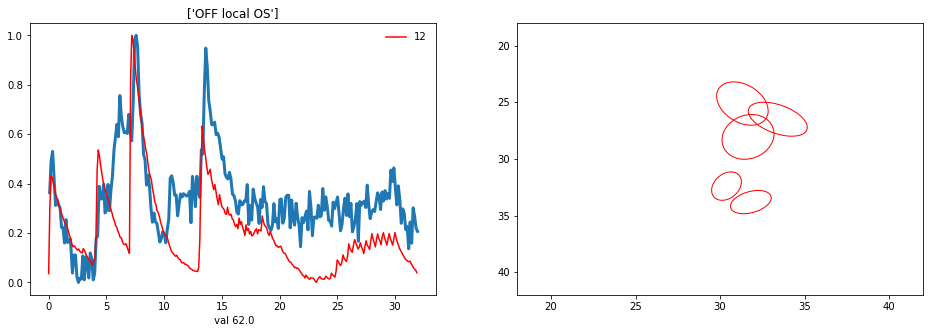

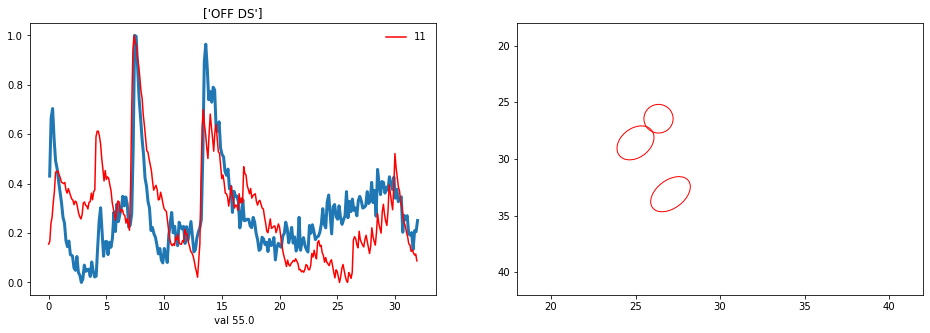

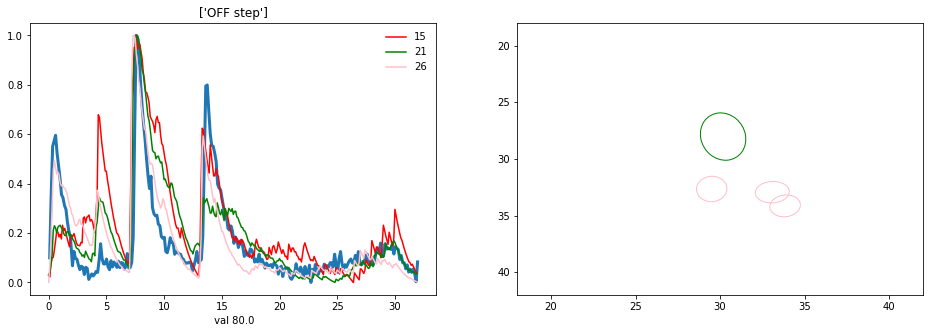

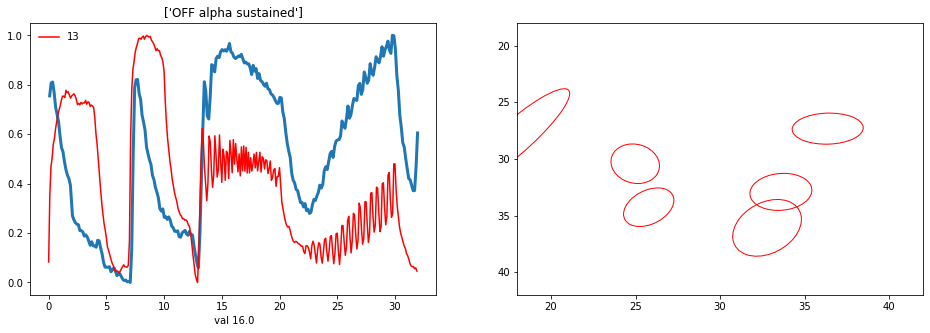

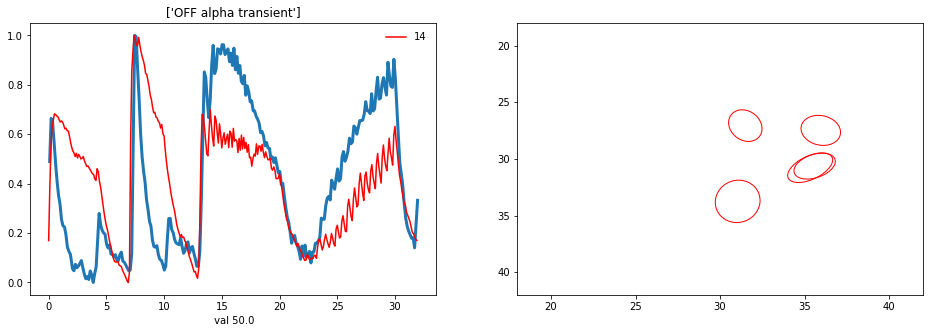

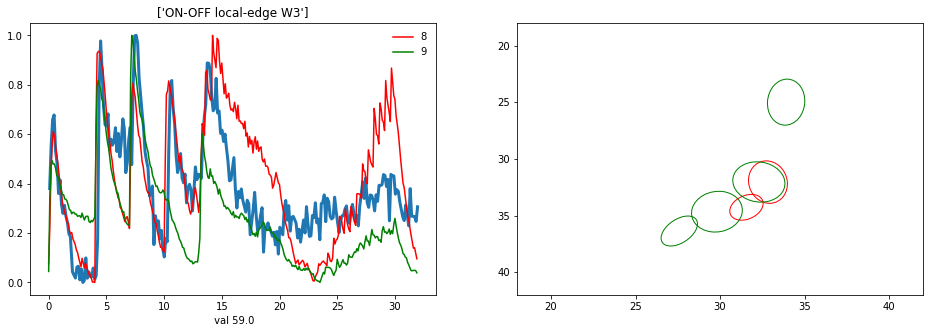

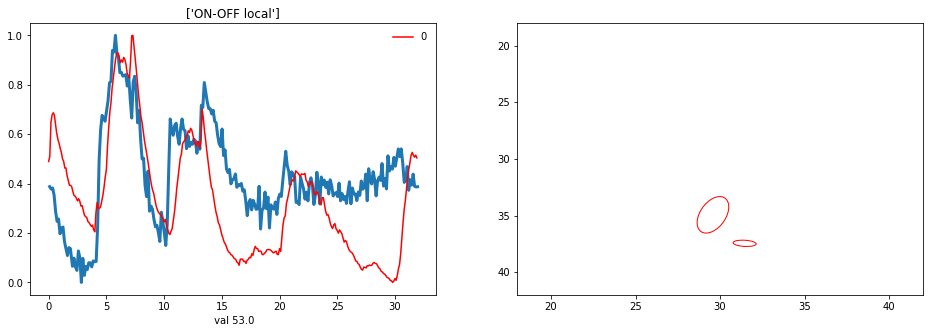

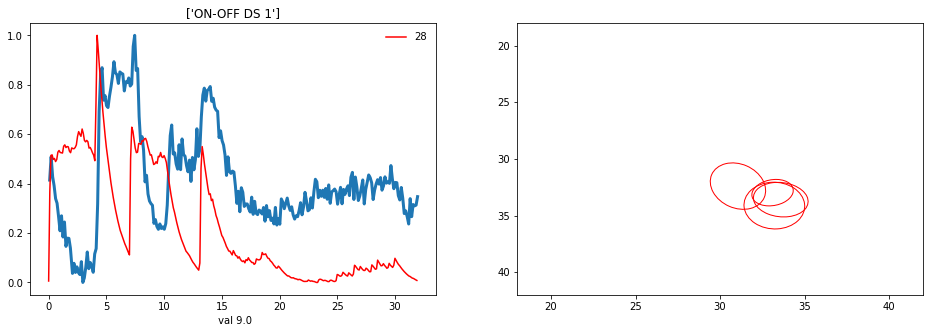

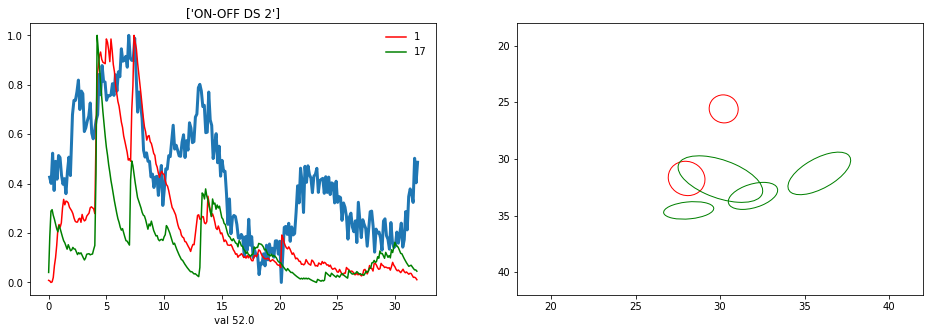

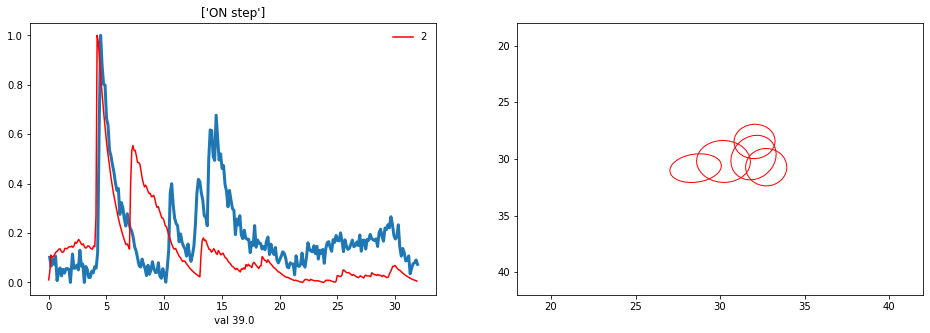

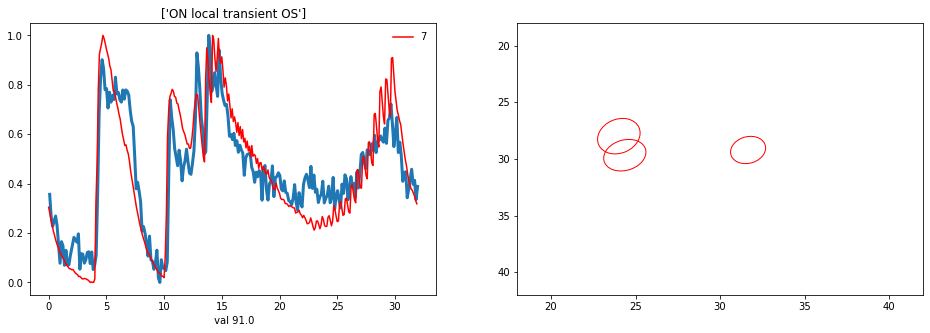

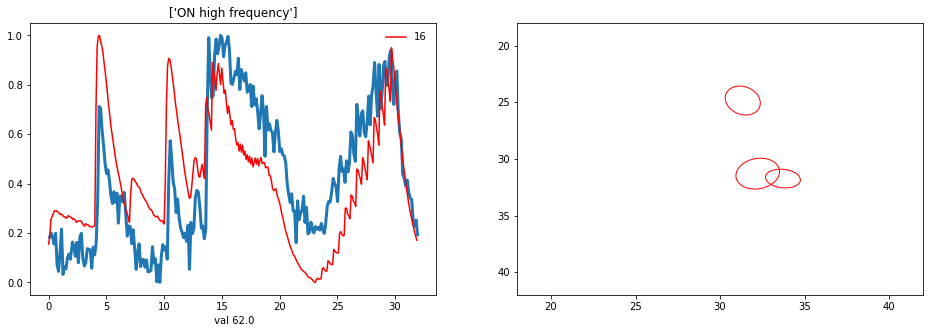

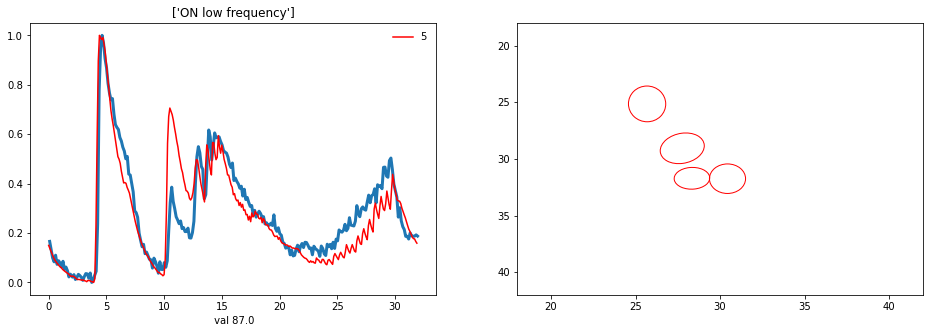

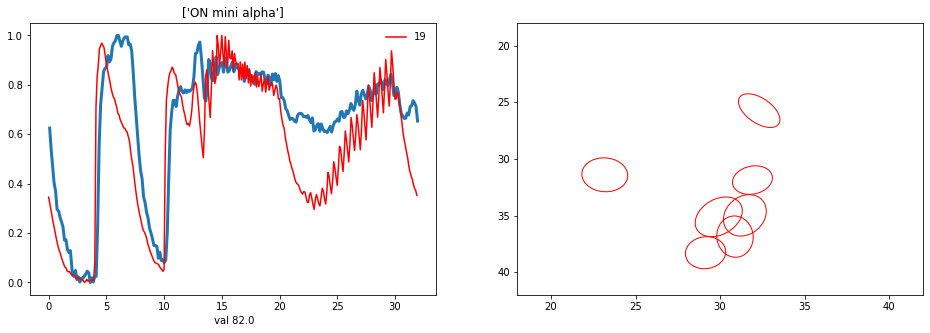

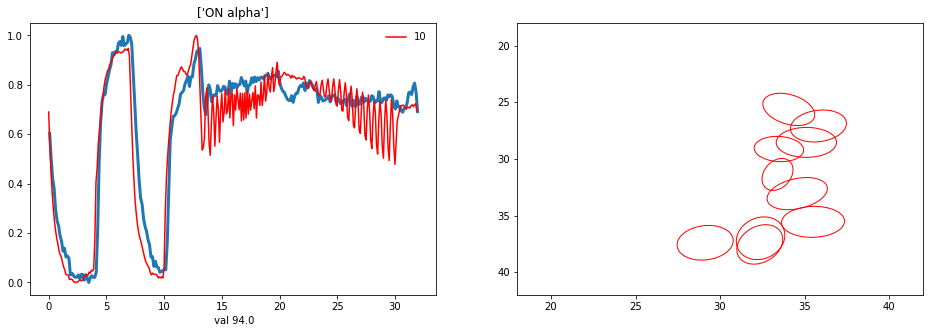

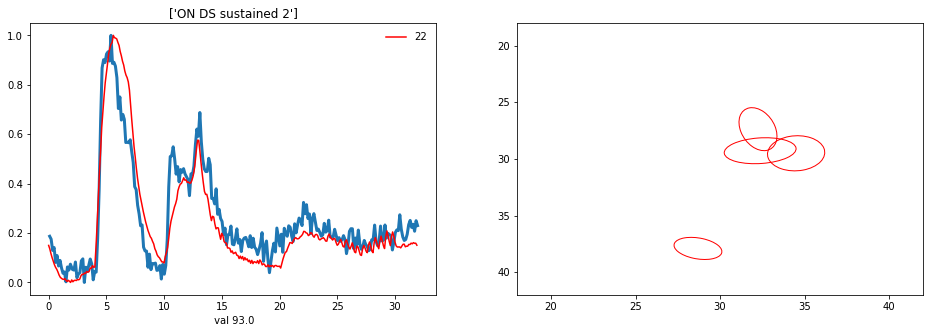

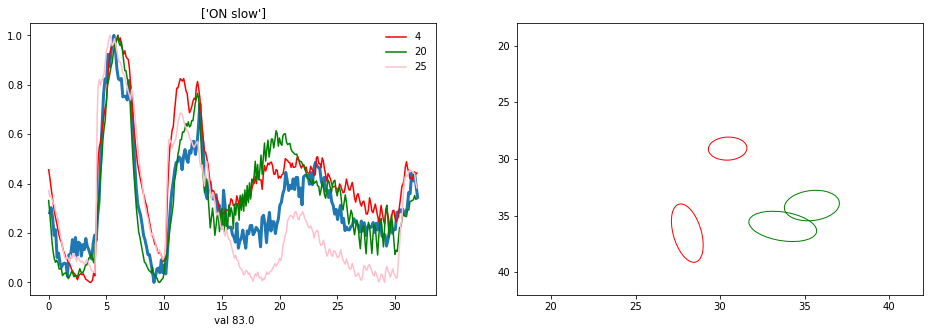

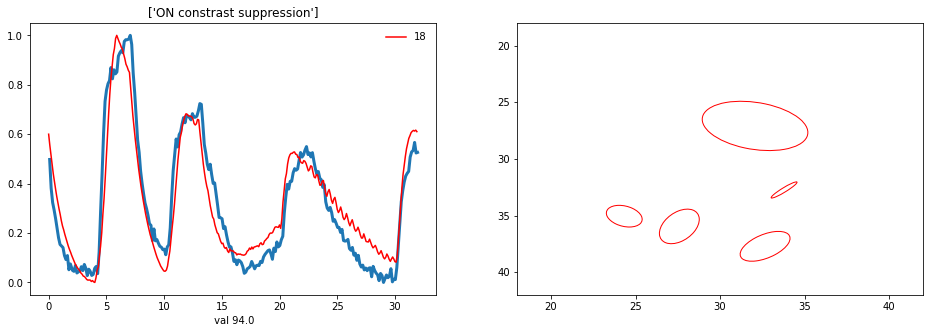

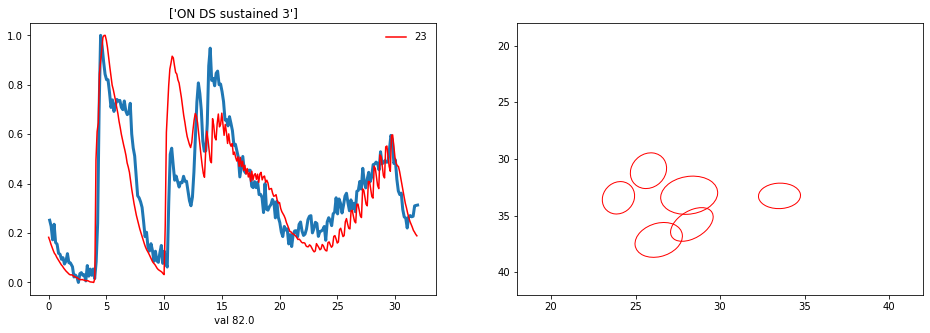

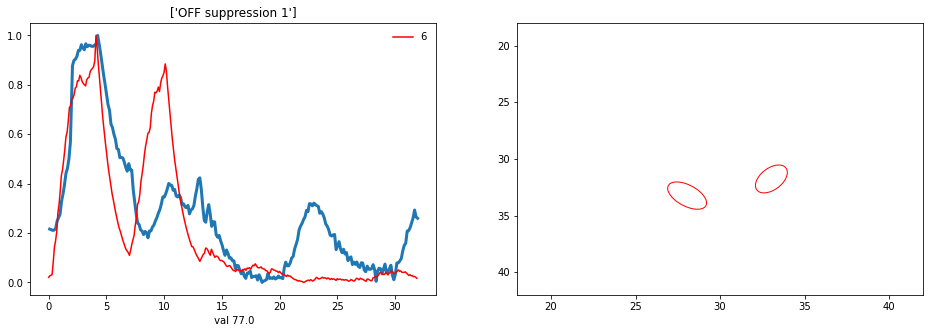

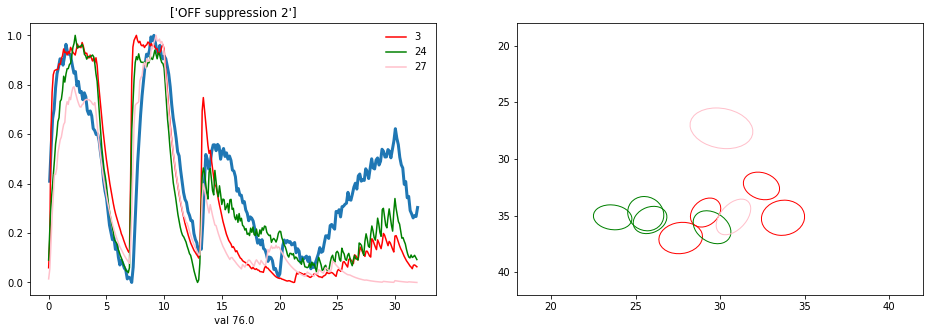

In [75]:
# Here plot the final groups

sel_badens = np.arange(32)
sel_exps = exp_labels

sel_cells = np.arange(29) #np.arange(15)

countg=0
for i in sel_badens:
    cc=0
    Plot=False
    for j in sel_cells:
        if manual_selection[j]==i:
            if not(Plot): 
                fig = figure(figsize=(16,5))
                ax1 = fig.add_subplot(1,2,1)
                ax2 = fig.add_subplot(1,2,2)
                ax1.plot(baden_time, Baden_types[i],lw=3)
                ax1.set_title(euler_labels[i])
                Plot=True
                countg+=1
            if Plot:
                ax1.plot(time, Exp_types_Ca[j], label = str(j), color=colors[cc+1])
                ax1.set_xlabel(' val '+str(np.round(man_vals[j]*100)) )#+ euler_labels[i][1])
                ax1.legend(frameon=False)
                
                clustersin = selected_cells[np.where((model.labels_==j))[0]]
                cc+=1
                for c in clustersin:
                    x_fit, y_fit, fitted_spatial_sta , parameters = fit_gaussian(cell_data[str(c)]["spatial_sta"])
                    x0, y0, width, height, angle = get_ellipse_parameters(parameters, factor=1)
                    xy = (x0, y0)
                    ellipse = pcs.Ellipse(xy, width, height, angle=angle, fill=False, color = colors[cc],lw=1)
                    ax2.add_patch(ellipse)
#                     ax2.plot(cell_data[c]['ellipseMat'][0]   , cell_data[c]['ellipseMat'][1] ,color=colors[cc] ,lw=0.5)#,lw=10)    #rotated ellipse
                ax2.set_xlim(18,42)
                ax2.set_ylim(42,18)
                print('Group',j, '   Baden ',i, euler_labels[i])
            
print('counts' ,countg)

### New cluster labels

In [76]:
new_labels = np.zeros(len(model.labels_))
for j in np.arange(len(model.labels_)):
    new_labels[j] = manual_selection[model.labels_[j]]

# here assign label to each cluster
Dic_labels={}
for i in np.arange(len(new_labels)):
    if new_labels[i]!=-1:
        Dic_labels.update({list(selected_cells)[i]: euler_labels[new_labels[i]]})
#--------------------
for c in sorted(list(Dic_labels.keys())):
     print('Clus ',c, '   Baden ',Dic_labels[c])

Clus  5    Baden  ['ON slow']
Clus  8    Baden  ['ON low frequency']
Clus  13    Baden  ['ON-OFF DS 1']
Clus  15    Baden  ['OFF step']
Clus  18    Baden  ['ON DS sustained 3']
Clus  47    Baden  ['ON constrast suppression']
Clus  48    Baden  ['OFF suppression 2']
Clus  54    Baden  ['ON-OFF DS 2']
Clus  89    Baden  ['ON-OFF DS 1']
Clus  96    Baden  ['OFF alpha sustained']
Clus  117    Baden  ['ON mini alpha']
Clus  122    Baden  ['ON mini alpha']
Clus  134    Baden  ['OFF step']
Clus  137    Baden  ['ON DS sustained 3']
Clus  141    Baden  ['ON-OFF DS 1']
Clus  148    Baden  ['ON-OFF local-edge W3']
Clus  152    Baden  ['ON step']
Clus  160    Baden  ['ON constrast suppression']
Clus  169    Baden  ['ON DS sustained 1']
Clus  177    Baden  ['ON slow']
Clus  201    Baden  ['OFF step']
Clus  215    Baden  ['ON alpha']
Clus  218    Baden  ['ON low frequency']
Clus  221    Baden  ['OFF suppression 2']
Clus  230    Baden  ['ON low frequency']
Clus  233    Baden  ['ON-OFF DS 1']
Clus  24

C:\Users\goethas\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\goethas\Anaconda3\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\goethas\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\goethas\Anaconda3\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\goethas\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\goethas\Anaconda3\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\goethas\Anaconda3\lib\site-package

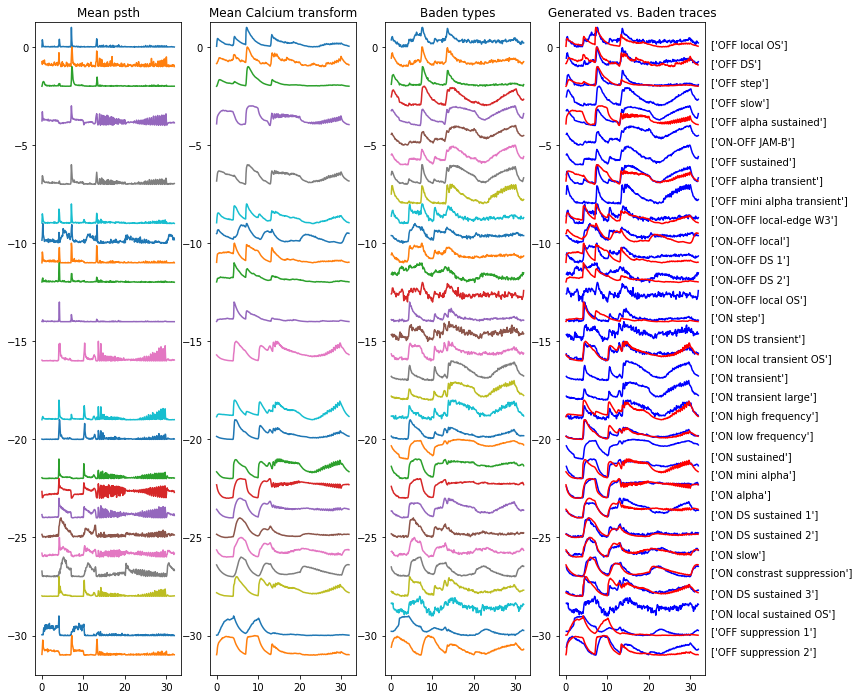

In [77]:
# Generate new experiment type traces
Exp_sorted_types = []

fig = figure(figsize=(12,12))

# Average MEA traces 
fig.add_subplot(1,4,1)
for i in euler_labels.keys():
    trace = np.mean(psth_z[(new_labels==i),:],0)
    trace = trace-min(trace)
    trace = trace/max(trace)
    Exp_sorted_types.append(trace)
    plot(time,trace-i)
    title('Mean psth')
    ylim([-32,1.25])
    
# Experiment to calcium
Exp_sorted_types_Ca = {}
fig.add_subplot(1,4,2)
for i in euler_labels.keys():
    trace = toCalciumLinear(time,Exp_sorted_types[i])
    Exp_sorted_types_Ca[i] = trace
    plot(time,trace-i)
    title('Mean Calcium transform')
    ylim([-32,1.25])
    
# Baden calcium traces
fig.add_subplot(1,4,3)
for i in euler_labels.keys():
    plot(baden_time,Baden_types[i]-i)
    ylim([-32,1.25])
    title('Baden types')

# Comparison
fig.add_subplot(1,4,4)
for i in euler_labels.keys():
    plot(baden_time,Baden_types[i]-i,'b')
    plot(time,Exp_sorted_types_Ca[i]-i,'r')
    text(35,-i,euler_labels[i])
    ylim([-32,1.25])
    title('Generated vs. Baden traces')

# Create a summary figure for each cluster type

In [79]:
for icluster in range(len(euler_labels))[0:]:
    idx_cluster = np.where(new_labels==icluster)[0]
    print(len(idx_cluster))
    
    if len(idx_cluster) > 0:

        gs = gds.GridSpec(len(idx_cluster)+3,6)

        if len(idx_cluster)<7:
            yspan = 2
        else:
            yspan=-2
        fig=figure(figsize=(14,(len(idx_cluster)+yspan)*1.75))
        plt.suptitle("Cell group {}   {}   {} cells".format(icluster,euler_labels[icluster], len(idx_cluster)),size=24)

        # Loop cells in cluster
        line = 2
        STAs=np.zeros(40)
        STAcount=0
        waves=np.zeros(101)
        wavecount=0
        
        for index in sorted(idx_cluster):
            cell_nb = str(list(selected_cells)[index])

            # Plot temp STA
            ax= subplot(gs[line+1,1])

            ax.set_ylim([-4,4])
            ax.axis("off")
            ax.set_aspect(0.075)
            ax.step(np.linspace(-40/30,0,40),cell_data[cell_nb]["temporal_sta"],'k',lw=3)
            polarity = cell_data[cell_nb]["polarity"]
            ax.set_title('Cluster ' + str(cell_nb) + '  Polarity '+polarity)
            ax.axhline(0,color='k',lw=0.5)

            STAs+=cell_data[cell_nb]["temporal_sta"]
            STAcount+=1

            # Plot temp STA avg
            ax= subplot(gs[0,1])

            ax.set_title('Temp STA')
            ax.set_ylim([-4,4])
            ax.plot(np.linspace(-40/30,0,40),cell_data[cell_nb]["temporal_sta"],lw=0.5)
            ax.axhline(0,color='k',lw=0.5)
            ax.set_xlabel('Time(s)')

            # plot Spatial STA
            ax= subplot(gs[line+1,0])
            ax.imshow(cell_data[cell_nb]["spatial_sta"], cmap='gray',interpolation='gaussian')
            ax.set_xlim(16,44)
            ax.set_ylim(44,16)
            ax.set_aspect('equal')
            ax.set_xticks([])
            ax.set_yticks([])

            #plot waveform
            ax= subplot(gs[line+1,2])
            wave = cell_data[cell_nb]["templates"]/abs(np.min(cell_data[cell_nb]["templates"]))
            ax.plot(wave,'r')
            ax.axis("off")
            ax.set_ylim([-1.25,1.25])
            waves+=wave
            wavecount+=1

            ax= subplot(gs[0,2])
            ax.plot(wave,lw=0.5)
            ax.axis("off")
            ax.set_ylim([-1.25,1.25])

            # plot Euler
            ax= subplot(gs[line+1,3:])
#             cell_index=list(selected_cells).index(cell_nb)
            ax.plot(np.linspace(0,32,800),cell_data[cell_nb]["psth"])
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.set_xticks([])
            plt.locator_params(axis="y", nbins=3)

            # plot Ellipse
            x_fit, y_fit, fitted_spatial_sta , parameters = fit_gaussian(cell_data[cell_nb]["spatial_sta"])

            x0, y0, width, height, angle = get_ellipse_parameters(parameters, factor=1)
            xy = (x0, y0)

            ax= subplot(gs[line+1,0])
            ellipse = pcs.Ellipse(xy, width, height, angle=angle, fill=False, color='r',lw=1)
            ax.add_patch(ellipse)

            ax= subplot(gs[0:2,0])
            ellipse = pcs.Ellipse(xy, width, height, angle=angle, fill=False, color='k',lw=1)
            ax.add_patch(ellipse)

            line+=1

        # avg STA
        STAs=STAs/STAcount
        ax= subplot(gs[0,1])
        ax.plot(np.linspace(-40/30,0,40),STAs,'k',lw=2)
        ax.set_ylim([-4,4])
        ax.set_aspect(0.075)
        ax.axis("off")

        # avg wave
        waves=waves/wavecount
        ax= subplot(gs[0,2])
        ax.set_title('Waveform')

        ax.plot(waves,'r',lw=2)
        ax.set_ylim([-1.25,1.25])
        #ax.set_aspect(0.075)
        ax.axis("off")

        # size ellipses
        ax= subplot(gs[0:2,0])

        ax.set_title('Ellipses')
        ax.set_xlim(16,44)
        ax.set_ylim(44,16)
        ax.set_aspect('equal')
        ax.set_xticks([])
        ax.set_yticks([])

        # mean psth
        ax= subplot(gs[0,3:])
        ax.set_title('Euler psth')

        ax.plot(np.linspace(0,32,320),np.mean(psth_z[idx_cluster,:], 0),'g')
        ax.axis("off")

        # mean Ca trace + comparison
        ax= subplot(gs[1,3:])
        ax.text(-9,1,'Calcium traces')
        ax.axis("off")

        plot(time,Exp_sorted_types_Ca[icluster] ,'g')
        plot(baden_time,Baden_types[icluster],'r')

#         # plot euler stim
#         euler_vec= get_euler()
#         ax= subplot(gs[2,3:])
#         ax.plot(time_stim,euler_vec, color='k')
#         ax.set_yticks([])
#         ax.set_ylim([-0.25,1.25])
#         ax.set_xlabel('Time(s)')
#         ax.spines['right'].set_visible(False)
#         ax.spines['bottom'].set_visible(False)
#         ax.spines['left'].set_visible(False)
#         ax.spines['top'].set_visible(False)

#         ax= subplot(gs[2,2])
#         ax.text(0.5,0.5 ,"Chirp stimulus profile")
#         ax.axis("off")
        
        ### Save figure

        PDF_folder = rootF + 'Documents/Myopia/Data analysis/Blur experiments/exp' + str(exp) + '/RGC typing/Baden types 14/'
        fsave = PDF_folder +'exp'+ str(exp) +'_badentype' +str(icluster) 

        fig.savefig(fsave+'.png',format='png',dpi=250)
        close(fig)  


5
3
16


C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:305: RuntimeWarning: divide by zero encountered in double_scalars
  a = + (np.cos(theta)**2) / (2 * sigma_x**2) + (np.sin(theta)**2) / (2 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:305: RuntimeWarning: invalid value encountered in double_scalars
  a = + (np.cos(theta)**2) / (2 * sigma_x**2) + (np.sin(theta)**2) / (2 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:306: RuntimeWarning: invalid value encountered in double_scalars
  b = - (np.sin(2 * theta)) / (4 * sigma_x**2) + (np.sin(2 * theta)) / (4 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:307: RuntimeWarning: invalid value encountered in double_scalars
  c = + (np.sin(theta)**2) / (2 * sigma_x**2) + (np.cos(theta)**2) / (2 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.p

0
6
0
0
5
0
6
2
8
10
0
5
0
3
0
0
3
5
0
7
16
5
5
7


C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:305: RuntimeWarning: divide by zero encountered in double_scalars
  a = + (np.cos(theta)**2) / (2 * sigma_x**2) + (np.sin(theta)**2) / (2 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:305: RuntimeWarning: invalid value encountered in double_scalars
  a = + (np.cos(theta)**2) / (2 * sigma_x**2) + (np.sin(theta)**2) / (2 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:306: RuntimeWarning: invalid value encountered in double_scalars
  b = - (np.sin(2 * theta)) / (4 * sigma_x**2) + (np.sin(2 * theta)) / (4 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:307: RuntimeWarning: invalid value encountered in double_scalars
  c = + (np.sin(theta)**2) / (2 * sigma_x**2) + (np.cos(theta)**2) / (2 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.p

7
6
0
2
11


# SAVE DATA

In [81]:
# Save average Ca traces for each type
fsave = exp_path + str(exp) + '_celltype_Ca_traces'
save_obj(Exp_sorted_types_Ca,fsave)

# Save Baden type for each cell in 'selected_cells'
fsave = exp_path + str(exp) + '_celltype_Baden'
save_obj(new_labels,fsave)

# Add blur data

## Load data

In [112]:
exp = 20230105

from shared.parameters_stimulation2 import *

if laptop:
    rootF = 'C:/Users/goethas/'
else:
    rootF = '/home/sarah/'

data_path = rootF + 'Documents/Myopia/Data analysis/Blur experiments/exp' + str(exp) + '/'

blur_data = load(data_path + str(exp) + '_selected_cells_spike_count_with_noise.npz')
    
spike_counts = blur_data['spike_count']
spike_counts_mean = blur_data['spike_count_mean']
spike_counts_std = blur_data['spike_count_std']
blur_clusters = blur_data['clusters']

Ncells = len(blur_clusters)

print (shape(spike_counts))
print (blur_clusters)

(188, 4, 2, 9, 4, 25)
[   5    8   13   15   18   33   47   48   50   50   54   64   89   96
  116  117  120  122  125  134  137  141  148  152  160  169  171  177
  178  201  207  215  218  221  230  233  240  246  248  255  268  269
  271  272  273  274  281  282  284  289  295  297  301  307  308  311
  320  326  329  330  334  337  345  347  350  353  355  356  368  374
  379  385  389  394  396  398  402  404  406  410  415  419  420  422
  424  425  434  445  451  454  462  469  480  482  498  501  508  510
  512  540  550  553  556  557  558  562  563  565  569  571  572  577
  578  580  583  585  586  589  590  596  598  600  606  609  620  621
  624  642  651  653  654  657  663  677  685  689  697  700  704  710
  719  733  741  744  759  765  777  783  791  798  817  829  832  856
  878  880  900  903  906  921  923  928  929  936  937  943  944  947
  951  957  962  964  966  970  975  976  979  982  985  990  998 1005
 1010 1018 1027 1030 1031 1039]


In [113]:
pup = 0

cols = ['C0','C1','C2','C3']

for icluster in range(len(euler_labels))[0:]:
    idx_cluster = np.where(new_labels==icluster)[0]
    print(len(idx_cluster))
    
    if len(idx_cluster) > 0:

        gs = gds.GridSpec(len(idx_cluster)+3,10)

        if len(idx_cluster)<7:
            yspan = 2
        else:
            yspan=-2
        fig=figure(figsize=(20,(len(idx_cluster)+yspan)*2))
        plt.suptitle("Cell group {}   {}   {} cells".format(icluster,euler_labels[icluster], len(idx_cluster)),size=24)

        # Loop cells in cluster
        line = 2
        STAs=np.zeros(40)
        STAcount=0
        waves=np.zeros(101)
        wavecount=0
        
        for index in sorted(idx_cluster):
            cell_nb = str(list(selected_cells)[index])

            # Plot temp STA
            ax= subplot(gs[line+1,1])

            ax.set_ylim([-4,4])
            ax.axis("off")
            ax.set_aspect(0.075)
            ax.step(np.linspace(-40/30,0,40),cell_data[cell_nb]["temporal_sta"],'k',lw=3)
            polarity = cell_data[cell_nb]["polarity"]
            ax.set_title('Cluster ' + str(cell_nb) + '  Polarity '+polarity)
            ax.axhline(0,color='k',lw=0.5)

            STAs+=cell_data[cell_nb]["temporal_sta"]
            STAcount+=1

            # Plot temp STA avg
            ax= subplot(gs[0,1])

            ax.set_title('Temp STA')
            ax.set_ylim([-4,4])
            ax.plot(np.linspace(-40/30,0,40),cell_data[cell_nb]["temporal_sta"],lw=0.5)
            ax.axhline(0,color='k',lw=0.5)
            ax.set_xlabel('Time(s)')

            # plot Spatial STA
            ax= subplot(gs[line+1,0])
            ax.imshow(cell_data[cell_nb]["spatial_sta"], cmap='gray',interpolation='gaussian')
            ax.set_xlim(16,44)
            ax.set_ylim(44,16)
            ax.set_aspect('equal')
            ax.set_xticks([])
            ax.set_yticks([])

            #plot waveform
            ax= subplot(gs[line+1,2])
            wave = cell_data[cell_nb]["templates"]/abs(np.min(cell_data[cell_nb]["templates"]))
            ax.plot(wave,'r')
            ax.axis("off")
            ax.set_ylim([-1.25,1.25])
            waves+=wave
            wavecount+=1

            ax= subplot(gs[0,2])
            ax.plot(wave,lw=0.5)
            ax.axis("off")
            ax.set_ylim([-1.25,1.25])

            # plot Euler
            ax= subplot(gs[line+1,3:6])
#             cell_index=list(selected_cells).index(cell_nb)
            ax.plot(np.linspace(0,32,800),cell_data[cell_nb]["psth"])
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.set_xticks([])
            plt.locator_params(axis="y", nbins=3)

            # plot Ellipse
            x_fit, y_fit, fitted_spatial_sta , parameters = fit_gaussian(cell_data[cell_nb]["spatial_sta"])

            x0, y0, width, height, angle = get_ellipse_parameters(parameters, factor=1)
            xy = (x0, y0)

            ax= subplot(gs[line+1,0])
            ellipse = pcs.Ellipse(xy, width, height, angle=angle, fill=False, color='r',lw=1)
            ax.add_patch(ellipse)

            ax= subplot(gs[0:2,0])
            ellipse = pcs.Ellipse(xy, width, height, angle=angle, fill=False, color='k',lw=1)
            ax.add_patch(ellipse)
            
            ##### Cells reponse to blur
            index_bl = where(blur_clusters == selected_cells[index])[0]
            print (selected_cells[index], blur_clusters[index_bl])
            if len(index_bl) > 0:
                index_bl = index_bl[0]
                max_act = nanmax(spike_counts_mean[index_bl])

                for src in range(Nsources):
                    ax = fig.add_subplot(gs[line+1, src + 6])
                    for iImg in range(Nimgs):
                        ax.plot(dFs, spike_counts_mean[index_bl, iImg, pup, :, src],'-', \
                                color=cols[iImg])
                        ax.spines['top'].set_visible(False)
                        ax.spines['right'].set_visible(False)
                        ax.set_ylim(0,1.5*max_act)
                        ax.set_xlim(0, 9)
                        ax.set_xticks(dFs[::2])
                        if line == 2:
                            ax.set_title('Ecc = {}°'.format(sourcesEcc[src]))
                            ax.set_xticklabels([])
                        if src == 0:
                            ax.set_ylabel('Spike cnt')
                        else:
                            ax.set_yticks([])
                        if line == len(idx_cluster)+1:
                            ax.set_xlabel('Defocus (D)')
                        else:
                            ax.set_xticks([])

            line+=1

        # avg STA
        STAs=STAs/STAcount
        ax= subplot(gs[0,1])
        ax.plot(np.linspace(-40/30,0,40),STAs,'k',lw=2)
        ax.set_ylim([-4,4])
        ax.set_aspect(0.075)
        ax.axis("off")

        # avg wave
        waves=waves/wavecount
        ax= subplot(gs[0,2])
        ax.set_title('Waveform')

        ax.plot(waves,'r',lw=2)
        ax.set_ylim([-1.25,1.25])
        #ax.set_aspect(0.075)
        ax.axis("off")

        # size ellipses
        ax= subplot(gs[0:2,0])

        ax.set_title('Ellipses')
        ax.set_xlim(16,44)
        ax.set_ylim(44,16)
        ax.set_aspect('equal')
        ax.set_xticks([])
        ax.set_yticks([])

        # mean psth
        ax= subplot(gs[0,3:6])
        ax.set_title('Euler psth')

        ax.plot(np.linspace(0,32,320),np.mean(psth_z[idx_cluster,:], 0),'g')
        ax.axis("off")

        # mean Ca trace + comparison
        ax= subplot(gs[1,3:6])
        ax.text(-9,1,'Calcium traces')
        ax.axis("off")

        plot(time,Exp_sorted_types_Ca[icluster] ,'g')
        plot(baden_time,Baden_types[icluster],'r')

        # plot euler stim
        euler_vec= get_euler()
        ax= subplot(gs[2,3:6])
        ax.plot(time_stim,euler_vec, color='k')
        ax.set_yticks([])
        ax.set_ylim([-0.25,1.25])
        ax.set_xlabel('Time(s)')
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['top'].set_visible(False)

        ax= subplot(gs[2,2])
        ax.text(0.5,0.5 ,"Chirp stimulus profile")
        ax.axis("off")
        
        ### Save figure

        PDF_folder = rootF + 'Documents/Myopia/Data analysis/Blur experiments/exp' + str(exp) + '/RGC typing/Baden types/'
        fsave = PDF_folder +'exp'+ str(exp) +'_blur_and_badentype' + str(icluster)

        fig.savefig(fsave+'.png',format='png',dpi=250)
        close(fig)  


5
368 [368]
398 [398]


C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

557 [557]
569 [569]


C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

578 [578]
3
589 [589]
923 [923]


C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

957 [957]
14
134 [134]
201 [201]


C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

281 [281]
282 [282]


C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

355 [355]


C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

420 [420]
424 [424]


C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

454 [454]
462 [462]


C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

482 [482]
562 [562]


C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

583 [583]
880 [880]


C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

936 [936]
5
272 [272]


C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

508 [508]
556 [556]


C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

765 [765]
966 [966]
6
96 [96]
330 [330]


C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

550 [550]
642 [642]


C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

733 [733]
741 [741]


C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

0
0
5
148 [148]
510 [510]


C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

900 [900]
906 [906]


C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

982 [982]
0
6
345 [345]
410 [410]


C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

415 [415]
540 [540]


C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

817 [817]
829 [829]


C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

2
798 [798]


C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

975 [975]
10
13 [13]


C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

15 [15]


C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

89 [89]
141 [141]


C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

233 [233]


C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:305: RuntimeWarning: divide by zero encountered in double_scalars
  a = + (np.cos(theta)**2) / (2 * sigma_x**2) + (np.sin(theta)**2) / (2 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:305: RuntimeWarning: invalid value encountered in double_scalars
  a = + (np.cos(theta)**2) / (2 * sigma_x**2) + (np.sin(theta)**2) / (2 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:306: RuntimeWarning: invalid value encountered in double_scalars
  b = - (np.sin(2 * theta)) / (4 * sigma_x**2) + (np.sin(2 * theta)) / (4 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:307: RuntimeWarning: invalid value encountered in double_scalars
  c = + (np.sin(theta)**2) / (2 * sigma_x**2) + (np.cos(theta)**2) / (2 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.p

320 [320]
943 [943]


C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

962 [962]
990 [990]


C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

1039 [1039]
7
54 [54]
255 [255]


C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

308 [308]
964 [964]


C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

979 [979]
1018 [1018]


C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

1030 [1030]
0
5
152 [152]


C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

326 [326]
389 [389]


C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

425 [425]
947 [947]


C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

0
3
284 [284]
406 [406]


C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

998 [998]
0
0
0
5
8 [8]


C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

218 [218]
230 [230]


C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

469 [469]
928 [928]


C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

4
5 [5]
663 [663]


C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

689 [689]
832 [832]


C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

7
117 [117]
122 [122]


C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

240 [240]
248 [248]


C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

404 [404]
577 [577]


C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

586 [586]
16
215 [215]
273 [273]


C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

356 [356]


C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

498 [498]
585 [585]


C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

596 [596]
598 [598]


C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

600 [600]
609 [609]


C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

620 [620]
657 [657]


C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

700 [700]
704 [704]


C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

719 [719]
744 [744]


C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

759 [759]
5
169 [169]


C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

301 [301]
590 [590]


C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

777 [777]
791 [791]


C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

4
394 [394]


C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

856 [856]
878 [878]


C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

929 [929]
5


C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:305: RuntimeWarning: divide by zero encountered in double_scalars
  a = + (np.cos(theta)**2) / (2 * sigma_x**2) + (np.sin(theta)**2) / (2 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:305: RuntimeWarning: invalid value encountered in double_scalars
  a = + (np.cos(theta)**2) / (2 * sigma_x**2) + (np.sin(theta)**2) / (2 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:306: RuntimeWarning: invalid value encountered in double_scalars
  b = - (np.sin(2 * theta)) / (4 * sigma_x**2) + (np.sin(2 * theta)) / (4 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:307: RuntimeWarning: invalid value encountered in double_scalars
  c = + (np.sin(theta)**2) / (2 * sigma_x**2) + (np.cos(theta)**2) / (2 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.p

177 [177]
295 [295]


C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

329 [329]
903 [903]


C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

944 [944]
7
47 [47]


C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

160 [160]
274 [274]


C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

396 [396]
558 [558]


C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

571 [571]
921 [921]
6
18 [18]
137 [137]


C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

451 [451]
565 [565]


C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

951 [951]
1005 [1005]


C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

0
2
311 [311]
970 [970]


C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

11
48 [48]


C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

221 [221]
269 [269]


C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

271 [271]
347 [347]


C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

422 [422]
553 [553]


C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

580 [580]
937 [937]


C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

976 [976]
1010 [1010]


C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_24052/1535137879.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converter